My GHH-Hackathon Project: Chess Piece Classfication using Conv Nets

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Download the dataset:

In [149]:
import pathlib
dataset_url = "https://raw.githubusercontent.com/JerryLiu8/GHH-Hackathon/main/Chess.tgz"
data_dir = tf.keras.utils.get_file('Chess', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [150]:
count = len(list(data_dir.glob('*/*')))
print(count)


556


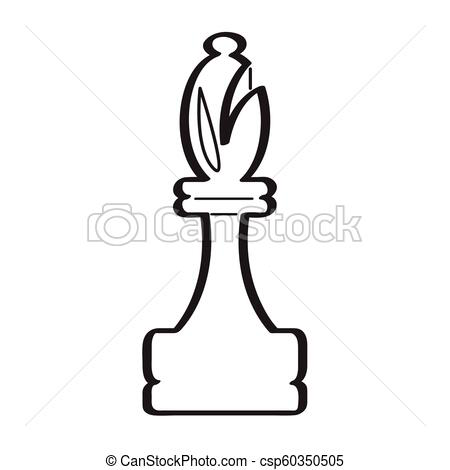

In [151]:
bishop = list(data_dir.glob('Bishop/*'))
PIL.Image.open(str(bishop[0]))

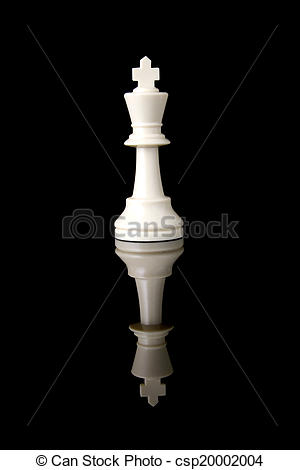

In [152]:
king = list(data_dir.glob('King/*'))
PIL.Image.open(str(king[0]))

In [153]:
batch_size = 16
img_height = 200
img_width = 200

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 552 files belonging to 6 classes.
Using 442 files for training.
Found 552 files belonging to 6 classes.
Using 110 files for validation.
['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']


Example Pieces:


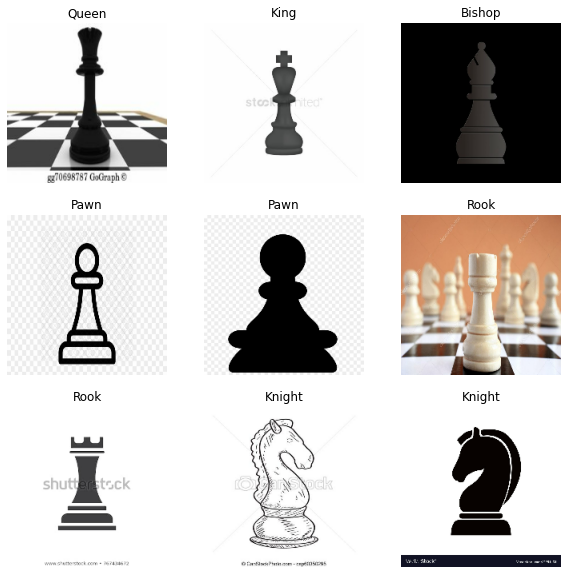

In [154]:
print("Example Pieces:")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [155]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

Data augmentation:

In [156]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

The Conv Net:

In [157]:
num_classes = 6

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compilation:

In [158]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling_20 (Rescaling)     (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 50, 50, 64)      

Training the CNN

In [159]:
epochs=40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
28/28 [==============================] - 21s 734ms/step - loss: 1.9608 - accuracy: 0.1380 - val_loss: 1.7901 - val_accuracy: 0.2000
Epoch 2/40
28/28 [==============================] - 19s 691ms/step - loss: 1.7913 - accuracy: 0.1968 - val_loss: 1.7841 - val_accuracy: 0.2182
Epoch 3/40
28/28 [==============================] - 19s 695ms/step - loss: 1.7877 - accuracy: 0.2081 - val_loss: 1.7673 - val_accuracy: 0.1818
Epoch 4/40
28/28 [==============================] - 19s 690ms/step - loss: 1.7714 - accuracy: 0.2149 - val_loss: 1.7223 - val_accuracy: 0.2818
Epoch 5/40
28/28 [==============================] - 19s 691ms/step - loss: 1.7191 - accuracy: 0.2602 - val_loss: 1.6807 - val_accuracy: 0.3182
Epoch 6/40
28/28 [==============================] - 24s 848ms/step - loss: 1.6576 - accuracy: 0.3213 - val_loss: 1.5966 - val_accuracy: 0.3455
Epoch 7/40
28/28 [==============================] - 19s 692ms/step - loss: 1.5847 - accuracy: 0.3258 - val_loss: 1.6137 - val_accuracy: 0.3455

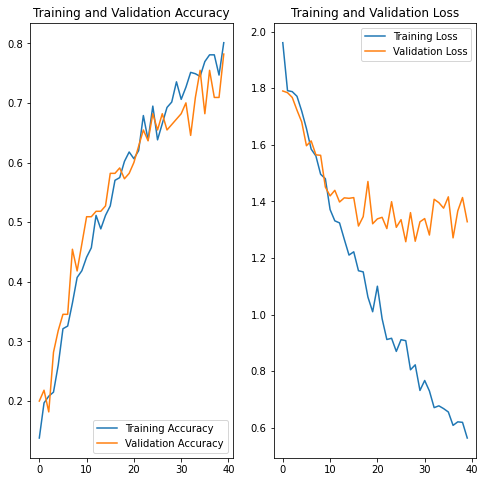

In [160]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict new images:

In [161]:
rook_url = "https://raw.githubusercontent.com/JerryLiu8/GHH-Hackathon/main/test%20set/rook.jpg"
rook_path = tf.keras.utils.get_file('rook', origin=rook_url)
print(rook_path)
img = keras.preprocessing.image.load_img(
    rook_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])

print(
    "This image is most likely a {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

/root/.keras/datasets/rook
[[-1.2415841  -3.2021952  -0.62674695  0.68715113 -0.2783211   1.548743  ]]
This image is most likely a Rook with a 56.59 percent confidence.


In [162]:
knight_url = "https://raw.githubusercontent.com/JerryLiu8/GHH-Hackathon/main/test%20set/knight.jpg"
knight_path = tf.keras.utils.get_file('knight', origin=knight_url)
print(knight_path)
img = keras.preprocessing.image.load_img(
    knight_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])

print(
    "This image is most likely a {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)



/root/.keras/datasets/knight
[[-5.203248   -4.2776957   2.8049154   0.09235404 -1.0341519   0.80647695]]
This image is most likely a Knight with a 81.66 percent confidence.
